In [1]:
import csv
import os
from collections import defaultdict
from datetime import datetime
from datetime import timedelta

import matplotlib
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
pd.options.display.max_rows = 999

In [3]:
sns.set()

In [4]:
%matplotlib inline

## Loading data

### Prestamos

In [5]:
%%time


dtypes = {
    'TITULO': str,
    'AUTOR': str,
    'SUCURSAL': str,
    'COD_BARRAS_LIBRO': str,
    'DEWEY': str,
    'DESC_LOCALIZACION_EJEMPLAR': str,
    'FECHA_PUB': str,
    'PAIS_EJEMPLAR': str,
    'OCUPACION': str,
    'NIVEL_EDUCACION': str,
    'AREA_ESTUDIO': str,
    'SUCURSAL_PRESTAMO': str,
    'SUCURSAL_DEVOLUCION': str,
    'SUCURSAL_DEL_LECTOR': str,
    'COD_BARRAS_LECTOR': str,
    'CATEGORÍA': str,
    'FECHA_PRESTAMO': str,
    'FECHA_REAL_DEVOLUCION': str,
    'DATE_PRESTAMO': str,
    'DATE_DEVOLUCION': str,
}

prestamos_df = pd.read_csv('prestamos_totales.csv', header=0, dtype=dtypes)
prestamos_df = prestamos_df.fillna('')

CPU times: user 12.4 s, sys: 1.16 s, total: 13.6 s
Wall time: 13.6 s


In [6]:
prestamos_df.shape

(3054360, 20)

In [7]:
prestamos_df.head()

,TITULO,AUTOR,SUCURSAL,COD_BARRAS_LIBRO,DEWEY,DESC_LOCALIZACION_EJEMPLAR,FECHA_PUB,PAIS_EJEMPLAR,OCUPACION,NIVEL_EDUCACION,AREA_ESTUDIO,SUCURSAL_PRESTAMO,SUCURSAL_DEVOLUCION,SUCURSAL_DEL_LECTOR,COD_BARRAS_LECTOR,CATEGORÍA,FECHA_PRESTAMO,FECHA_REAL_DEVOLUCION,DATE_PRESTAMO,DATE_DEVOLUCION
0,Un bicho extraño,"Daporta, Mon.",ARM,2298061,863,Infantil,2010,sp,,,,ARM,ARM,ARM,88429527,CTA,22/01/2015,04/02/2015,2015-01-22,2015-02-04
1,Un bicho extraño,"Daporta, Mon.",ARM,2298061,863,Infantil,2010,sp,,,,ARM,ARM,ARM,88416381,CTA,31/03/2015,07/04/2015,2015-03-31,2015-04-07
2,Quisiera tener ...,"Zoboli, Giovanna.",ARM,2284458,853,Infantil,2010,mx,,,,ARM,ARM,ARM,88381353,CTA,07/11/2015,17/11/2015,2015-11-07,2015-11-17
3,Johannes Gutenberg,"Borràs Perelló, Lluís.",ARM,2288922,925,Infantil,2010,sp,Empleado,Técnico,Adm. de empresas,ARM,ARM,ARM,88007424,CEM,16/01/2015,16/01/2015,2015-01-16,2015-01-16
4,La fantástica leyenda de: la princesa y el dragón,"Alins, Sonia.",ARM,2288896,863,Infantil,2010,sp,,,,ARM,ARM,ARM,88429529,CTA,21/01/2015,28/01/2015,2015-01-21,2015-01-28


### Sucursales

In [8]:
sucursales = {
    'ARM': 'Armenia',
    'BLAA': 'Luis Angel Arango',
    'BUE': 'Buenaventura',
    'CAL': 'Cali',
    'CAR': 'Cartagena',
    'CASAGO': 'Casa Gómez Campuzano',
    'CATMAN': 'Catalogación y Mantenimiento de Colecciones',
    'CUC': 'Cúcuta',
    'FLO': 'Florencia',
    'GIR': 'Girardot',
    'HON': 'Honda',
    'IBA': 'Ibagué',
    'IEC': 'Investigaciones Económicas',
    'IPI': 'Ipiales',
    'LET': 'Leticia',
    'MAN': 'Manizales',
    'MED': 'Medellín',
    'MON': 'Montería',
    'NEI': 'Neiva',
    'PAS': 'Pasto',
    'PER': 'Pereira',
    'POP': 'Popayán',
    'QUI': 'Quibdó',
    'RIO': 'Riohacha',
    'SAN': 'San Andrés',
    'SIN': 'Sincelejo',
    'STM': 'Santa Marta',
    'TUN': 'Tunja',
    'VAL': 'Valledupar',
}

### Topics

0. Class 000 - Computer science, information & general works
1. Class 100 - Philosophy & psychology
2. Class 200 - Religion
3. Class 300 - Social sciences
4. Class 400 - Language
5. Class 500 - Science
6. Class 600 - Technology
7. Class 700 - Arts & recreation
8. Class 800 - Literature
9. Class 900 - History & geography

In [9]:
gdewey_dct = {
    '0': 'Computer science,\ninformation,\n& general works',
    '1': 'Philosophy & psychology',
    '2': 'Religion',
    '3': 'Social sciences',
    '4': 'Language',
    '5': 'Science',
    '6': 'Technology',
    '7': 'Arts & recreation',
    '8': 'Literature',
    '9': 'History & geography',
}

In [10]:
def keys(d):
    return sorted(d)

def values(d):
    return [d[k] for k in keys(d)]

In [11]:
topics = {}
with open('dewey.txt') as f:
    for line in f:
        chunks = line.strip().split()
        dewey = chunks[0]
        topic = ' '.join(chunks[1:])
        topics[dewey] = topic

### Usuarios

1.       CTA: categoría para niños y jóvenes hasta bachillerato
2.       CTI: categoría infantil, hasta doce años y solo es para Bogotá (blaa –biblioteca Luis Ángel Arango)
3.       CTB: público general (solo permite préstamo de libros)
4.       CTC: público en general (permite préstamo de libros y material audiovisual)
5.       CTF: categoría familiar, pueden acceder a los beneficios hasta tres personas del grupo familiar que se asocia
6.       CE1, CE2, CE2: categorías empresariales (solo para instituciones)
7.       CIS: categoría Inclusión Social
8.       CTU: categoría Universitaria
9.       VIP: Investigadores, préstamo de 30 materiales (libros y material audiovisual)

0.     Categoría de lector: CE1 Categoría empresarial                                   218
1.     Categoría de lector: CE2 Categoría empresarial 2                                   5
2.     Categoría de lector: CEM Categoría Empleado/Pensionado                          1593
3.     Categoría de lector: CIN Categoría Interbibliotecario                            128
4.     Categoría de lector: CIP Categoría Investigador                                  351
5.     Categoría de lector: CIS Categoría Inclusión Preferencial                      15974
6.     Categoría de lector: CIV Categoría Investigadores                                 72
7.     Categoría de lector: CML Categoría Mediador de Proyectos Culturales                2
8.     Categoría de lector: CSU Categoría Sucursal                                       91
9.     Categoría de lector: CTA Categoría Básica A                                    10610
0.     Categoría de lector: CTB Categoría B                                            1359
1.     Categoría de lector: CTC Categoría C                                             224
2.     Categoría de lector: CTF Categoría familiar                                     1105
3.     Categoría de lector: CTI Categoría Infantil                                     1004
4.     Categoría de lector: CTU Categoría General                                     17402
5.     Categoría de lector: PTE PROCESOS TÉCNICOS                                       95

## Pre-processing data

In [12]:
prestamos_df.head()

,TITULO,AUTOR,SUCURSAL,COD_BARRAS_LIBRO,DEWEY,DESC_LOCALIZACION_EJEMPLAR,FECHA_PUB,PAIS_EJEMPLAR,OCUPACION,NIVEL_EDUCACION,AREA_ESTUDIO,SUCURSAL_PRESTAMO,SUCURSAL_DEVOLUCION,SUCURSAL_DEL_LECTOR,COD_BARRAS_LECTOR,CATEGORÍA,FECHA_PRESTAMO,FECHA_REAL_DEVOLUCION,DATE_PRESTAMO,DATE_DEVOLUCION
0,Un bicho extraño,"Daporta, Mon.",ARM,2298061,863,Infantil,2010,sp,,,,ARM,ARM,ARM,88429527,CTA,22/01/2015,04/02/2015,2015-01-22,2015-02-04
1,Un bicho extraño,"Daporta, Mon.",ARM,2298061,863,Infantil,2010,sp,,,,ARM,ARM,ARM,88416381,CTA,31/03/2015,07/04/2015,2015-03-31,2015-04-07
2,Quisiera tener ...,"Zoboli, Giovanna.",ARM,2284458,853,Infantil,2010,mx,,,,ARM,ARM,ARM,88381353,CTA,07/11/2015,17/11/2015,2015-11-07,2015-11-17
3,Johannes Gutenberg,"Borràs Perelló, Lluís.",ARM,2288922,925,Infantil,2010,sp,Empleado,Técnico,Adm. de empresas,ARM,ARM,ARM,88007424,CEM,16/01/2015,16/01/2015,2015-01-16,2015-01-16
4,La fantástica leyenda de: la princesa y el dragón,"Alins, Sonia.",ARM,2288896,863,Infantil,2010,sp,,,,ARM,ARM,ARM,88429529,CTA,21/01/2015,28/01/2015,2015-01-21,2015-01-28


In [13]:
def group_dewey(x):
    try:
        int(x)
        r = x[0]
    except:
        r = ''
    return r

prestamos_df['GDEWEY'] = prestamos_df['DEWEY'].apply(group_dewey)

In [14]:
prestamos_df.CATEGORÍA.value_counts()

CTB    1241305
CTA     464123
CTC     412350
CTF     333510
CTU     151930
CEM     106300
CE1      80702
CSU      77940
CIS      64114
CIN      53376
CTI      36276
CE2      17398
CIV      11069
CIP       3958
CAN          8
CE3          1
Name: CATEGORÍA, dtype: int64

In [15]:
def get_year(x):
    return x.split('/')[-1]

prestamos_df['YEAR'] = prestamos_df['FECHA_PRESTAMO'].apply(get_year)

In [16]:
prestamos_df.YEAR.value_counts().sort_index()

2012    677551
2013    658150
2014    607554
2015    548997
2016    562108
Name: YEAR, dtype: int64

In [17]:
p_df = prestamos_df[prestamos_df['GDEWEY'] != '']

In [18]:
p_df.GDEWEY.value_counts()

8    923712
3    701250
6    257117
7    239411
1    210738
9    207929
5    198839
0     82294
2     55328
4     46178
Name: GDEWEY, dtype: int64

In [19]:
p_df.shape

(2922796, 22)

## Processing data

### Query #1

In [20]:
query1a_sr = p_df.groupby(['CATEGORÍA', 'GDEWEY']).TITULO.count()
query1b_sr = p_df.groupby(['GDEWEY', 'CATEGORÍA']).TITULO.count()

In [21]:
query1a_sr.head()

CATEGORÍA  GDEWEY
CAN        3             4
CE1        0          2947
           1          5263
           2          1299
           3         18307
Name: TITULO, dtype: int64

In [22]:
query1b_sr.head()

GDEWEY  CATEGORÍA
0       CE1          2947
        CE2           569
        CEM          3958
        CIN          2588
        CIP            76
Name: TITULO, dtype: int64

In [23]:
q1_g = nx.Graph()
for (category, gdewey), n in query1a_sr.iteritems():
    if category not in q1_g:
        a = query1a_sr[category].sum()
        q1_g.add_node(category, type='User category', weight=int(a))
    if gdewey not in q1_g:
        b = query1b_sr[gdewey].sum()
        q1_g.add_node(gdewey_dct[gdewey], type='Dewey class', weight=int(b))
    q1_g.add_edge(category, gdewey_dct[gdewey], weight=int(n))

In [24]:
q1_g.number_of_nodes()

26

In [25]:
q1_g.number_of_edges()

142

In [26]:
q1_g.number_of_selfloops()

0

In [27]:
# nx.write_gexf(q1_g, 'queries/q1.gexf')

#### Metrics

##### Minimum degree

In [28]:
min_deg1 = min((q1_g.degree(n), n) for n in q1_g.nodes)

In [29]:
min_deg1

(1, 'CAN')

##### Maximum degree

In [30]:
max_deg1 = max((q1_g.degree(n), n) for n in q1_g.nodes)

In [31]:
max_deg1

(15, 'Social sciences')

##### Betweenness centrality

In [32]:
bc1 = nx.betweenness_centrality(q1_g)

In [33]:
bc1_df = pd.DataFrame(
    pd.Series(bc1),
    columns=['Betweenness Centrality'],
).sort_values('Betweenness Centrality', ascending=False)

In [34]:
bc1_df

,Betweenness Centrality
Social sciences,0.110333
Religion,0.110333
Arts & recreation,0.030333
"Computer science,\ninformation,\n& general works",0.030333
Science,0.030333
Philosophy & psychology,0.030333
Literature,0.030333
Language,0.030333
History & geography,0.030333
Technology,0.030333


### Query #2

In [35]:
query2a_sr = p_df.groupby(['SUCURSAL_PRESTAMO', 'GDEWEY']).TITULO.count()
query2b_sr = p_df.groupby(['GDEWEY', 'SUCURSAL_PRESTAMO']).TITULO.count()

In [36]:
query2a_sr.head()

SUCURSAL_PRESTAMO  GDEWEY
ARM                0          945
                   1         1542
                   2          288
                   3         3458
                   4          216
Name: TITULO, dtype: int64

In [37]:
query2b_sr.head()

GDEWEY  SUCURSAL_PRESTAMO
0       ARM                    945
        BAR                    268
        BLAA                 42745
        BUC                   1101
        BUE                    156
Name: TITULO, dtype: int64

In [38]:
q2_g = nx.Graph()
for (branch, gdewey), n in query2a_sr.iteritems():
    if branch not in q2_g:
        a = query2a_sr[branch].sum()
        q2_g.add_node(branch, type='Library branch', weight=int(a))
    if gdewey not in q2_g:
        b = query2b_sr[gdewey].sum()
        q2_g.add_node(gdewey_dct[gdewey], type='Dewey class', weight=int(b))
    q2_g.add_edge(branch, gdewey_dct[gdewey], weight=int(n))

In [39]:
q2_g.number_of_nodes()

43

In [40]:
q2_g.number_of_edges()

321

In [41]:
q2_g.number_of_selfloops()

0

In [42]:
nx.write_gexf(q2_g, 'queries/q2.gexf')

#### Metrics

##### Minimum degree

In [43]:
min_deg2 = min((q2_g.degree(n), n) for n in q2_g.nodes)

In [44]:
min_deg2

(1, 'IEC')

##### Maximum degree

In [45]:
max_deg2 = max((q2_g.degree(n), n) for n in q2_g.nodes)

In [46]:
max_deg2

(33, 'Social sciences')

##### Betweenness centrality

In [47]:
bc2 = nx.betweenness_centrality(q2_g)

In [48]:
bc2_df = pd.DataFrame(
    pd.Series(bc2),
    columns=['Betweenness Centrality'],
).sort_values('Betweenness Centrality', ascending=False)

In [49]:
bc2_df

,Betweenness Centrality
Social sciences,0.105226
Language,0.057607
Religion,0.057607
Arts & recreation,0.057607
History & geography,0.057607
Philosophy & psychology,0.057607
"Computer science,\ninformation,\n& general works",0.057607
Science,0.057607
Technology,0.057607
Literature,0.057607


### Query #3

In [50]:
top_titles_df = pd.read_csv('queries/15_titulos.csv')

In [51]:
top_titles_sr = top_titles_df.set_index('TÍTULO')['VOLUMEN']

In [52]:
top_titles_sr

TÍTULO
Obras completas                                                 4060
Física                                                          2013
Cien años de soledad                                            1997
Cuentos completos                                               1950
Biología                                                        1777
Química                                                         1745
Metodología de la investigación                                 1605
Algebra lineal                                                  1549
Cuentos                                                         1539
Rayuela                                                         1501
Antología poética                                               1485
Cálculo                                                         1457
El amor en los tiempos del cólera                               1451
Física universitaria                                            1368
Química orgánica           

In [53]:
top_titles_lst = top_titles_df['TÍTULO'].tolist()

In [54]:
p_df2 = p_df[p_df.TITULO.isin(top_titles_lst)]

In [55]:
p_df2.shape

(37084, 22)

In [56]:
query3a_sr = p_df2.groupby(['SUCURSAL_PRESTAMO', 'TITULO']).COD_BARRAS_LIBRO.count()
query3b_sr = p_df2.groupby(['SUCURSAL_PRESTAMO', 'CATEGORÍA']).COD_BARRAS_LIBRO.count()
query3c_sr = p_df2.groupby(['CATEGORÍA', 'TITULO']).COD_BARRAS_LIBRO.count()

In [57]:
query3a_sr.head()

SUCURSAL_PRESTAMO  TITULO                             
ARM                Alicia en el país de las maravillas    46
                   Antología poética                       8
                   Biología                                4
                   Cien años de soledad                    8
                   Crimen y castigo                        2
Name: COD_BARRAS_LIBRO, dtype: int64

In [58]:
query3b_sr.head()

SUCURSAL_PRESTAMO  CATEGORÍA
ARM                CE1          14
                   CEM          16
                   CIS           6
                   CSU           9
                   CTA          74
Name: COD_BARRAS_LIBRO, dtype: int64

In [59]:
query3c_sr.head()

CATEGORÍA  TITULO                             
CE1        Algebra lineal                         14
           Alicia en el país de las maravillas    32
           Antología poética                      22
           Biología                                8
           Cien años de soledad                   29
Name: COD_BARRAS_LIBRO, dtype: int64

In [60]:
%%time

q3_g = nx.Graph()
for i, row in p_df2.iterrows():
    title = row['TITULO']
    branch = row['SUCURSAL_PRESTAMO']
    category = row['CATEGORÍA']
    if title not in q3_g:
        m = top_titles_sr[title]
        q3_g.add_node(title, type='Title', weight=int(m))
    if branch not in q3_g:
        b = query3b_sr[branch].sum()
        q3_g.add_node(branch, type='Library branch', weight=int(b))
    if category not in q3_g:
        c = query3c_sr[category].sum()
        q3_g.add_node(category, type='User category', weight=int(c))
    x = query3a_sr[branch][title]
    y = query3b_sr[branch][category]
    z = query3c_sr[category][title]
    q3_g.add_edge(branch, title, weight=int(x))
    q3_g.add_edge(branch, category, weight=int(y))
    q3_g.add_edge(category, title, weight=int(z))

CPU times: user 34.2 s, sys: 36 ms, total: 34.3 s
Wall time: 34.2 s


In [61]:
q3_g.number_of_nodes()

70

In [62]:
q3_g.number_of_edges()

1227

In [63]:
q3_g.number_of_selfloops()

0

In [64]:
nx.write_gexf(q3_g, 'queries/q3.gexf')

#### Metrics

##### Minimum degree

In [65]:
min_deg3 = min((q3_g.degree(n), n) for n in q3_g.nodes)

In [66]:
min_deg3

(4, 'CATMAN')

##### Maximum degree

In [67]:
max_deg3 = max((q3_g.degree(n), n) for n in q3_g.nodes)

In [68]:
max_deg3

(55, 'CTB')

##### Betweenness centrality

In [69]:
bc3 = nx.betweenness_centrality(q3_g)

In [70]:
bc3_df = pd.DataFrame(
    pd.Series(bc3),
    columns=['Betweenness Centrality'],
).sort_values('Betweenness Centrality', ascending=False)

In [71]:
bc3_df

,Betweenness Centrality
CSU,0.022309
Antología poética,0.021688
CTB,0.017929
CTF,0.015959
Química,0.015840
El amor en los tiempos del cólera,0.014942
Cien años de soledad,0.014106
Cuentos,0.013862
CEM,0.013841
Cuentos completos,0.013316


### Query #4

In [72]:
query4_sr = p_df.groupby(['YEAR', 'GDEWEY']).TITULO.count()
query4_df = query4_sr.unstack('GDEWEY')

In [73]:
query4_df

GDEWEY,0,1,2,3,4,5,6,7,8,9
YEAR,,,,,,,,,,
2012,18249,49104,13029,158962,10008,50940,67045,56487,173241,45393
2013,16755,46765,12484,153684,9689,44408,59110,52986,186139,45448
2014,16067,43143,11171,141896,9739,38843,51125,48033,182096,42628
2015,15243,36974,9578,125755,8309,32325,40963,41588,181592,37330
2016,15980,34752,9066,120953,8433,32323,38874,40317,200644,37130


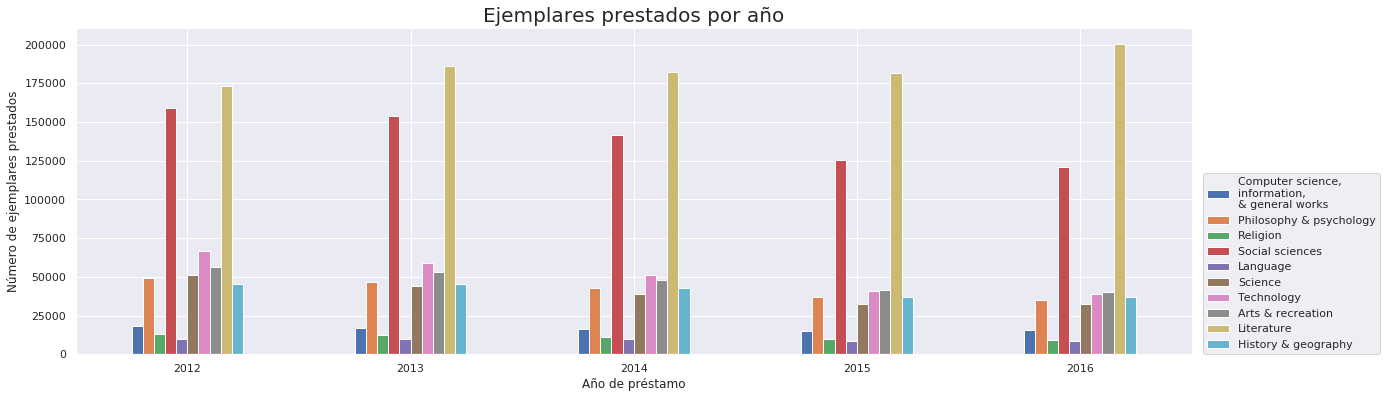

In [74]:
ax = query4_df.plot(
    kind='bar',
    figsize=(20, 6),
    rot=0,
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, values(gdewey_dct), loc=(1.01, 0))#, prop={'size': 10})
ax.set(xlabel='Año de préstamo', ylabel='Número de ejemplares prestados')
ax.set_title('Ejemplares prestados por año', fontsize=20);

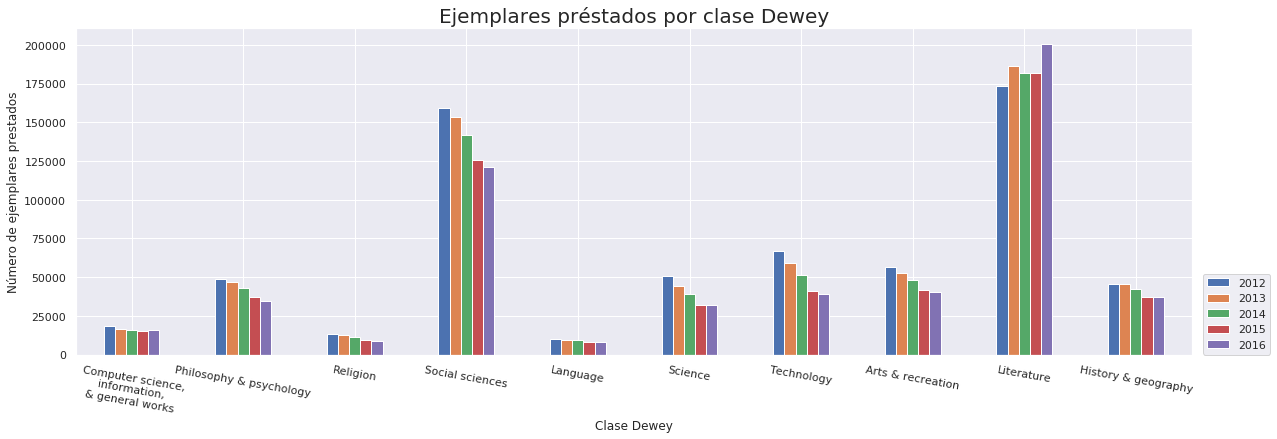

In [75]:
bx = query4_df.T.plot(
    kind='bar',
    figsize=(20, 6),
    rot=-10,
)
handles, labels = bx.get_legend_handles_labels()
bx.legend(handles, labels, loc=(1.01, 0))#, prop={'size': 10})
bx.set(xlabel='Clase Dewey', ylabel='Número de ejemplares prestados')
bx.set_xticklabels(values(gdewey_dct))
bx.set_title('Ejemplares préstados por clase Dewey', fontsize=20);

### Frequency distributions of Literature and Social Sciences

In [76]:
pdf2 = prestamos_df[(prestamos_df['GDEWEY'] == '8') | (prestamos_df['GDEWEY'] == '3')]

#### By user category

In [77]:
sr8a = pdf2[pdf2.GDEWEY == '8']['CATEGORÍA'].value_counts()
sr3a = pdf2[pdf2.GDEWEY == '3']['CATEGORÍA'].value_counts()

In [78]:
pdf83a = pd.DataFrame(
    {
        'Literature': sr8a,
        'Social Sciences': sr3a,
    },
)

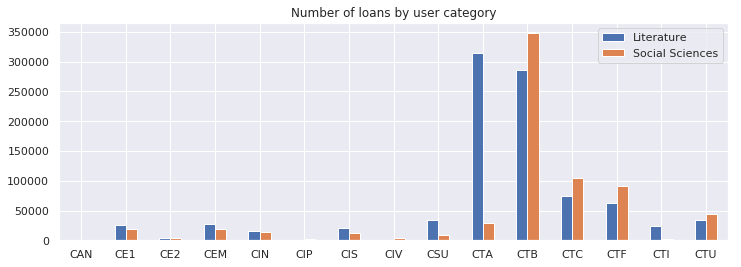

In [79]:
pdf83a.plot(kind='bar', rot=0, figsize=(12,4), title='Number of loans by user category');

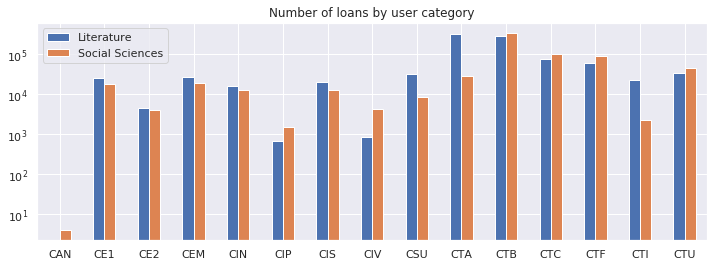

In [80]:
pdf83a.plot(kind='bar', rot=0, figsize=(12,4), title='Number of loans by user category', logy=True);

#### By sucursal

In [81]:
sr8b = pdf2[pdf2.GDEWEY == '8']['SUCURSAL_PRESTAMO'].value_counts()
sr3b = pdf2[pdf2.GDEWEY == '3']['SUCURSAL_PRESTAMO'].value_counts()

In [82]:
pdf83b = pd.DataFrame(
    {
        'Literature': sr8b,
        'Social Sciences': sr3b,
    },
)

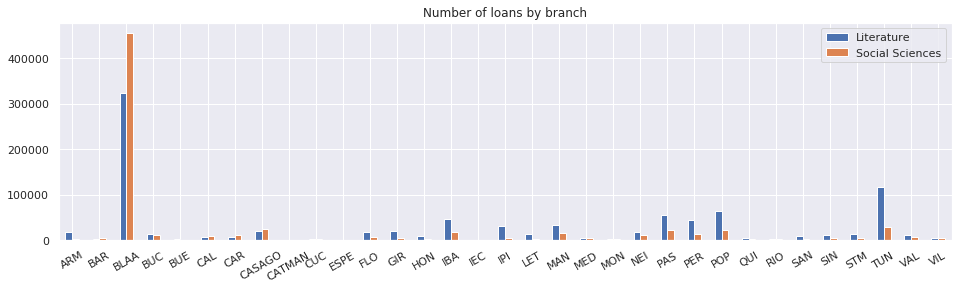

In [83]:
pdf83b.plot(kind='bar', rot=30, figsize=(16,4), title='Number of loans by branch');

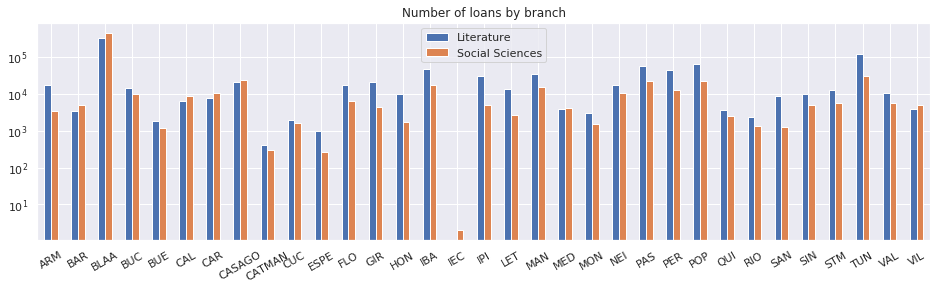

In [100]:
pdf83b.plot(kind='bar', rot=30, figsize=(16,4), title='Number of loans by branch', logy=True);

### Degree of Literature and Social Sciences

#### Dewey and user category

In [84]:
q1_g.degree('Literature')

14

In [85]:
neighbors1a = list(q1_g.neighbors('Literature'))

In [86]:
neighbors1a

['CTI',
 'CE1',
 'CTA',
 'CIP',
 'CE2',
 'CEM',
 'CTF',
 'CIV',
 'CTU',
 'CTC',
 'CSU',
 'CIS',
 'CTB',
 'CIN']

In [87]:
q1_g.degree('Social sciences')

15

In [88]:
neighbors1b = list(q1_g.neighbors('Social sciences'))

In [89]:
neighbors1b

['CTI',
 'CAN',
 'CE1',
 'CTA',
 'CIP',
 'CE2',
 'CEM',
 'CTF',
 'CIV',
 'CTU',
 'CTC',
 'CSU',
 'CIS',
 'CTB',
 'CIN']

In [90]:
set(neighbors1a) - set(neighbors1b)

set()

In [91]:
set(neighbors1b) - set(neighbors1a)

{'CAN'}

#### Dewey and branch

In [92]:
q2_g.degree('Literature')

32

In [93]:
neighbors2a = list(q2_g.neighbors('Literature'))

In [94]:
neighbors2a

['GIR',
 'RIO',
 'ARM',
 'MAN',
 'IBA',
 'HON',
 'QUI',
 'MON',
 'MED',
 'TUN',
 'BUC',
 'CATMAN',
 'SIN',
 'LET',
 'BAR',
 'IPI',
 'CAR',
 'VAL',
 'FLO',
 'CASAGO',
 'SAN',
 'PAS',
 'STM',
 'PER',
 'NEI',
 'BLAA',
 'BUE',
 'POP',
 'VIL',
 'CAL',
 'ESPE',
 'CUC']

In [95]:
q2_g.degree('Social sciences')

33

In [96]:
neighbors2b = list(q2_g.neighbors('Social sciences'))

In [97]:
neighbors2b

['GIR',
 'RIO',
 'ARM',
 'MAN',
 'IBA',
 'HON',
 'QUI',
 'MON',
 'MED',
 'TUN',
 'BUC',
 'CATMAN',
 'SIN',
 'LET',
 'BAR',
 'IPI',
 'CAR',
 'VAL',
 'FLO',
 'CASAGO',
 'SAN',
 'PAS',
 'STM',
 'PER',
 'NEI',
 'BLAA',
 'IEC',
 'BUE',
 'POP',
 'VIL',
 'CAL',
 'ESPE',
 'CUC']

In [98]:
set(neighbors2a) - set(neighbors2b)

set()

In [99]:
set(neighbors2b) - set(neighbors2a)

{'IEC'}

### Viajes libros

In [107]:
viajes_df = prestamos_df[prestamos_df['SUCURSAL'] != prestamos_df['SUCURSAL_PRESTAMO']]

In [108]:
viajes_df.shape

(490031, 22)

In [109]:
viajes_df.head()

,TITULO,AUTOR,SUCURSAL,COD_BARRAS_LIBRO,DEWEY,DESC_LOCALIZACION_EJEMPLAR,FECHA_PUB,PAIS_EJEMPLAR,OCUPACION,NIVEL_EDUCACION,...,SUCURSAL_DEVOLUCION,SUCURSAL_DEL_LECTOR,COD_BARRAS_LECTOR,CATEGORÍA,FECHA_PRESTAMO,FECHA_REAL_DEVOLUCION,DATE_PRESTAMO,DATE_DEVOLUCION,GDEWEY,YEAR
20,Humo,"Fortes Torres, Antón, 1957-",ARM,2346909,863,Infantil,2008,sp,Estudiante,Profesional,...,BUC,BUC,88413167,CTC,16/04/2015,21/04/2015,2015-04-16,2015-04-21,8,2015
67,En la laguna más profunda,"Collazos, Oscar, 1942-2015.",ARM,2316575,863,Centro Documentación Regional,2011,ck,Cultural,,...,VIL,VIL,88208571,CIN,10/06/2015,12/06/2015,2015-06-10,2015-06-12,8,2015
102,The X-men: volumen 1,"Lee, Stan, 1922-.",ARM,2251968,741,Centro Documentación Regional,2007,sp,Empleado,Profesional,...,CASAGO,CASAGO,88449906,CTC,14/10/2015,20/10/2015,2015-10-14,2015-10-20,7,2015
118,El templo del sol,"Hergé, 1907-1983.",ARM,2255539,843,Infantil,2006,fr,Estudiante,Universitario 1 nivel,...,PER,PER,88438916,CTB,18/07/2015,25/07/2015,2015-07-18,2015-07-25,8,2015
141,Borracho en parranda santa,"Vallejo Betancur, Alejandro.",ARM,1486502,863,Centro Documentación Regional,2009,ck,Estudiante,Maestría,...,PER,PER,88455036,CTB,01/06/2015,16/06/2015,2015-06-01,2015-06-16,8,2015


In [111]:
%%time


viajes_g = nx.DiGraph()
for i, row in viajes_df.iterrows():
    suc_ejemplar = row['SUCURSAL']
    suc_prestamo = row['SUCURSAL_PRESTAMO']
    if suc_ejemplar not in viajes_g:
        viajes_g.add_node(suc_ejemplar, type='Library branch', weight=1)
    else:
        viajes_g.node[suc_ejemplar]['weight'] += 1
    if suc_prestamo not in viajes_g:
        viajes_g.add_node(suc_prestamo, type='Library branch', weight=1)
    else:
        viajes_g.node[suc_prestamo]['weight'] += 1
    if not viajes_g.has_edge(suc_ejemplar, suc_prestamo):
        viajes_g.add_edge(suc_ejemplar, suc_prestamo, weight=1)
    else:
        viajes_g[suc_ejemplar][suc_prestamo]['weight'] += 1

### Query Viajes

In [133]:
viajes_df.head()

,TITULO,AUTOR,SUCURSAL,COD_BARRAS_LIBRO,DEWEY,DESC_LOCALIZACION_EJEMPLAR,FECHA_PUB,PAIS_EJEMPLAR,OCUPACION,NIVEL_EDUCACION,...,SUCURSAL_DEVOLUCION,SUCURSAL_DEL_LECTOR,COD_BARRAS_LECTOR,CATEGORÍA,FECHA_PRESTAMO,FECHA_REAL_DEVOLUCION,DATE_PRESTAMO,DATE_DEVOLUCION,GDEWEY,YEAR
20,Humo,"Fortes Torres, Antón, 1957-",ARM,2346909,863,Infantil,2008,sp,Estudiante,Profesional,...,BUC,BUC,88413167,CTC,16/04/2015,21/04/2015,2015-04-16,2015-04-21,8,2015
67,En la laguna más profunda,"Collazos, Oscar, 1942-2015.",ARM,2316575,863,Centro Documentación Regional,2011,ck,Cultural,,...,VIL,VIL,88208571,CIN,10/06/2015,12/06/2015,2015-06-10,2015-06-12,8,2015
102,The X-men: volumen 1,"Lee, Stan, 1922-.",ARM,2251968,741,Centro Documentación Regional,2007,sp,Empleado,Profesional,...,CASAGO,CASAGO,88449906,CTC,14/10/2015,20/10/2015,2015-10-14,2015-10-20,7,2015
118,El templo del sol,"Hergé, 1907-1983.",ARM,2255539,843,Infantil,2006,fr,Estudiante,Universitario 1 nivel,...,PER,PER,88438916,CTB,18/07/2015,25/07/2015,2015-07-18,2015-07-25,8,2015
141,Borracho en parranda santa,"Vallejo Betancur, Alejandro.",ARM,1486502,863,Centro Documentación Regional,2009,ck,Estudiante,Maestría,...,PER,PER,88455036,CTB,01/06/2015,16/06/2015,2015-06-01,2015-06-16,8,2015


In [132]:
queryA_sr = viajes_df.groupby(['SUCURSAL', 'SUCURSAL_PRESTAMO']).TITULO.count()
queryB_sr = viajes_df.groupby(['SUCURSAL_PRESTAMO', 'SUCURSAL']).TITULO.count()

In [136]:
queryA_sr

SUCURSAL  SUCURSAL_PRESTAMO
ARM       BAR                     32
          BLAA                   185
          BUC                    259
          BUE                      7
          CAL                    206
          CAR                      3
          CASAGO                 119
          CUC                     38
          ESPE                     1
          FLO                     13
          GIR                     12
          HON                      1
          IBA                     21
          IPI                      2
          LET                      4
          MAN                     49
          MED                     23
          MON                     27
          NEI                     36
          PAS                     29
          PER                     85
          POP                     30
          QUI                      2
          RIO                      6
          SAN                      2
          SIN                      1
          

In [135]:
queryB_sr.head()

SUCURSAL_PRESTAMO  SUCURSAL
ARM                BLAA        9416
                   BUE           73
                   CAL           50
                   CAR          218
                   CASAGO        84
Name: TITULO, dtype: int64

In [137]:
viajes2_g = nx.DiGraph()
for (suc_ejemplar, suc_prestamo), n in queryA_sr.iteritems():
    if suc_ejemplar not in viajes2_g:
#         a = queryA_sr[suc_ejemplar].sum()
        viajes2_g.add_node(suc_ejemplar, type='Library branch', weight=int(a))
#     if suc_prestamo not in viajes2_g:
#         b = queryB_sr[suc_prestamo].sum()
#         viajes2_g.add_node(suc_prestamo, type='Library branch', weight=int(b))
    viajes2_g.add_edge(suc_ejemplar, suc_prestamo, weight=int(n))

In [117]:
viajes_g.number_of_nodes()

33

In [116]:
viajes2_g.number_of_nodes()

33

In [119]:
viajes_g.number_of_edges()

829

In [118]:
viajes2_g.number_of_edges()

829

In [121]:
viajes_g.number_of_selfloops()

0

In [120]:
viajes2_g.number_of_selfloops()

0

In [123]:
viajes_g.degree('BLAA')

59

In [122]:
viajes2_g.degree('BLAA')

59

In [138]:
nx.write_gexf(viajes2_g, 'queries/viajes.gexf')

#### Metrics

##### Minimum degree

In [139]:
min_deg1 = min((viajes2_g.degree(n), n) for n in viajes2_g.nodes)

In [140]:
min_deg1

(1, 'IEC')

##### Maximum degree

In [141]:
max_deg1 = max((viajes2_g.degree(n), n) for n in viajes2_g.nodes)

In [142]:
max_deg1

(59, 'BLAA')

##### Betweenness centrality

In [143]:
bc1 = nx.betweenness_centrality(viajes2_g)

In [144]:
bc1_df = pd.DataFrame(
    pd.Series(bc1),
    columns=['Betweenness Centrality'],
).sort_values('Betweenness Centrality', ascending=False)

In [145]:
bc1_df

,Betweenness Centrality
BLAA,0.033686
IBA,0.002436
TUN,0.002436
CAR,0.002436
POP,0.002436
PER,0.002436
PAS,0.002436
NEI,0.002436
IPI,0.002131
BUE,0.001704
